# REINFORCE in TensorFlow

Just like we did before for Q-learning, this time we'll design a TensorFlow network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [44]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [46]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

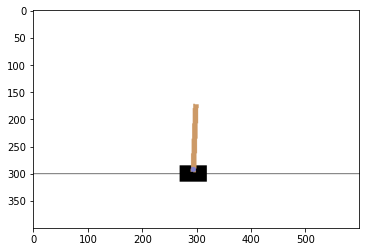

In [47]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [48]:
import tensorflow as tf


In [49]:
# create input variables. We only need <s, a, r> for REINFORCE
states = tf.placeholder('float32',(None,)+state_dim,name="states")
actions = tf.placeholder('int32',name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [50]:
from keras.models import Sequential
from keras.layers import Dense
import keras.layers as L

logits = L.Dense(n_actions)(states)

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

In [53]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0]

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [52]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cum_rewards = [0] * len(rewards)
    cum_rewards[-1] = rewards[-1]
    for i in reversed(range(len(rewards)-1)):
        cum_rewards[i] = rewards[i] + gamma * cum_rewards[i+1]
        
    return cum_rewards

In [54]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse Tensorflow's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [55]:
#get probabilities for parti
indices = tf.stack([tf.range(tf.shape(log_policy)[0]),actions],axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [56]:
# Policy objective as in the last formula. Please use reduce_mean, not reduce_sum.
# You may use log_policy_for_actions to get log probabilities for actions taken.
# Also recall that we defined ph_cumulative_rewards earlier.

J = tf.reduce_mean(log_policy_for_actions*cumulative_rewards)

As a reminder, for a discrete probability distribution (like the one our policy outputs), entropy is defined as:

$$ \operatorname{entropy}(p) = -\sum_{i = 1}^n p_i \cdot \log p_i $$

In [57]:
# Entropy regularization. If you don't add it, the policy will quickly deteriorate to
# being deterministic, harming exploration.

entropy = -tf.reduce_sum(policy * log_policy)

In [58]:
# # Maximizing X is the same as minimizing -X, hence the sign.
loss = -(J + 0.001 * entropy)

update = tf.train.AdamOptimizer().minimize(loss)

In [59]:
def train_on_session(states, actions, rewards, t_max=1000):
    """given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        states: states,
        actions: actions,
        cumulative_rewards: cumulative_rewards,
    })
    return sum(rewards)

In [65]:
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})

In [60]:
# Initialize optimizer parameters
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Play the game

We can now use our newly built agent to play the game.

In [75]:
def generate_session(env, t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)        
        a = np.random.choice([0,1],p=action_probas)        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states,actions,rewards)
            
    return sum(rewards)

### The actual training

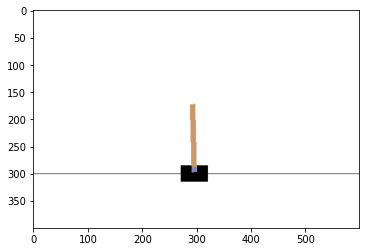

In [67]:
env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

env.close()

In [69]:
for i in range(100):    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("epoch %d, mean reward:%.3f"%(i, np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break

epoch 0, mean reward:240.040
epoch 1, mean reward:286.840
epoch 2, mean reward:251.560
epoch 3, mean reward:244.530
epoch 4, mean reward:210.810
epoch 5, mean reward:249.330
epoch 6, mean reward:274.490
epoch 7, mean reward:299.690
epoch 8, mean reward:349.860
You Win!


### Results & video

In [71]:
#record sessions
import gym
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [77]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)        
        a = np.random.choice([0,1],p=action_probas)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [78]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'groddenator@gmail.com', 'LL49sVCoKXS1BShs')

Your average reward is 301.56 over 100 episodes
Submitted to Coursera platform. See results on assignment page!


That's all, thank you for your attention!

Not having enough? There's an actor-critic waiting for you in the honor section. But make sure you've seen the videos first.